# Arabic Hate Speech Detection 

## Imports

In [2]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from farasa.stemmer import FarasaStemmer
from farasa.segmenter import FarasaSegmenter 
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

# Modeling
from transformers import BertTokenizer, BertForSequenceClassification
import torch

import warnings
warnings.filterwarnings('ignore')

## Processing

We have 5 different datasets, we need to standardize and encode their labels before we can combine them

### Dataset 1

In [6]:
# Read dataset file 
df1 = pd.read_csv('data/dataset_1.csv')

# Take only the two columns we're interested in
df1 = df1[['Text','Toxic/Not Toxic']]

# Rename columns to have the same columns names across all dataframes
df1.set_axis(['text','label'], axis=1, inplace=True)

df1.head(3)

,text,label
0,علي #العالم أن يؤدب هذه الدوله المجنونه إيران ...,Toxic
1,إسرائيل هي اوهن من بيت العنكبون,Toxic
2,‏إذا تمكنت من اكتشاف الحيوان الثاني الموجود با...,Not Toxic


In [8]:
# Encode labels, Not Toxic -> 0, Toxic -> 1
df1.loc[df1['label'] != 'Not Toxic', 'label'] = 1
df1.loc[df1['label'] == 'Not Toxic', 'label'] = 0
df1.head(3)

,text,label
0,علي #العالم أن يؤدب هذه الدوله المجنونه إيران ...,1
1,إسرائيل هي اوهن من بيت العنكبون,1
2,‏إذا تمكنت من اكتشاف الحيوان الثاني الموجود با...,0


The same preprocessing steps apply to all datasets

### Dataset 2

In [12]:
# Read and combine train and test splits
df2_1 = pd.read_csv('data/dataset_2/train.csv')
df2_2 = pd.read_csv('data/dataset_2/test.csv')
df2 = pd.concat([df2_1, df2_2], axis=0)

# Take only the two columns we're interested in
df2 = df2[['Tweet','Class']]

# Rename columns to have the same columns names across all dataframes
df2.set_axis(['text','label'], axis=1, inplace=True)

df2.head(5)

,text,label
0,وزير الخارجية اللبناني جبران باسيل قال في سلسل...,normal
1,سورية بلد الحضارات تربطها بعلية او بحيوان,normal
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,normal
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكرة قلهم...,normal
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,abusive


In [13]:
# Encode labels
df2.loc[df2['label'] != 'normal', 'label'] = 1
df2.loc[df2['label'] == 'normal', 'label'] = 0
df2.head(5)

,text,label
0,وزير الخارجية اللبناني جبران باسيل قال في سلسل...,0
1,سورية بلد الحضارات تربطها بعلية او بحيوان,0
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,0
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكرة قلهم...,0
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,1


### Dataset 3

In [16]:
# Read dataset
df3 = pd.read_csv('data/dataset_3.csv')
df3 = df3[['tweet','sentiment']]
df3.set_axis(['text','label'], axis=1, inplace=True)
df3.head(4)

,text,label
0,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,hateful_normal
1,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,offensive
2,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,offensive
3,@user @user انا اوافقك بخصوص السوريين و العراق...,normal


In [17]:
# Encode labels
df3.loc[df3['label'] != 'normal', 'label'] = 1
df3.loc[df3['label'] == 'normal', 'label'] = 0
df3.head(4)

,text,label
0,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,1
1,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,1
2,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,1
3,@user @user انا اوافقك بخصوص السوريين و العراق...,0


### Dataset 4

In [18]:
# Read dataset
df4 = pd.read_csv('data/dataset_4.csv', sep='\t')
df4 = df4[['Tweet','Class']]
df4.set_axis(['text','label'], axis=1, inplace=True)
df4.head(5)

,text,label
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive


In [19]:
# Encode labels
df4.loc[df4['label'] != 'normal', 'label'] = 1
df4.loc[df4['label'] == 'normal', 'label'] = 0
df4.head(5)

,text,label
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,1
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,0
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,0
3,وليد جنبلاط كاتب الحكمة يا قذر,1
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,1


### Dataset 5

In [20]:
# Read dataset
df5 = pd.read_excel('data/dataset_5.xlsx', engine='openpyxl')
df5 = df5[['text','aggregatedAnnotation']].dropna()
df5.set_axis(['text','label'], axis=1, inplace=True)
df5.head(4)

,text,label
0,مبروك و سامحونا لعجزنا التام. عقبال اللي جوه. ...,0.0
1,كلنا بره ومش هنبطل نزايد على العجايز الي جابون...,-1.0
2,بدل ما انت قاعد بره كده تعالي ازرع الصحرا,0.0
3,قذر اتفووو ماتيجى مصر وتورينا نفسك كدا ياجبان,-1.0


In [21]:
# Encode labels
df5.loc[df5['label'] != 0, 'label'] = 1
df5['label'] = df5['label'].astype(int)
df5.head(4)

,text,label
0,مبروك و سامحونا لعجزنا التام. عقبال اللي جوه. ...,0
1,كلنا بره ومش هنبطل نزايد على العجايز الي جابون...,1
2,بدل ما انت قاعد بره كده تعالي ازرع الصحرا,0
3,قذر اتفووو ماتيجى مصر وتورينا نفسك كدا ياجبان,1


### Combine Datasets

Now we're gonna combine all five datasets into one dataframe

In [22]:
# Concatenate all dataframes
df = pd.concat([df1, df2, df3, df4, df5], axis=0)

# Randomly shuffle the dataframe
df = df.sample(frac = 1, random_state=42).reset_index(drop=True)

df.head(5)

,text,label
0,ايران هي المسؤله رقم واحد عن تعطيل العهد و مع ...,0
1,مهو كمان يلي بينتقد أردوغان وبيمدح ملكه هاد هو...,1
2,أودي فقضية التحرش فالمغرب، بلا مندويو على الأش...,1
3,حسبنا الله ونعم الوكيل فيهم سلطة الخونة والجوا...,1
4,بغض النظر عن إنه كلهن كلاب بس حتى الإمارات وصل...,1


Now let's check if our dataset is balanced or not

Text(0.5, 1.0, 'Dataset Labels')

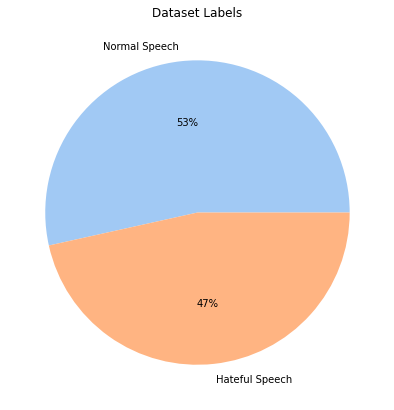

In [23]:
label_count = df.groupby(['label']).size()
plot_labels = ['Normal Speech', 'Hateful Speech']
label_count = list(label_count)
colors = sns.color_palette('pastel')
plt.figure(figsize=(7,7))
plt.pie(label_count, labels=plot_labels, colors=colors, autopct='%.0f%%')
plt.title('Dataset Labels')

Great! we have a balanced dataset

Now let's apply stemming and segmentation to the text in our dataset using Farasa library

In [15]:
# Initialize stemmer and segmenter
stemmer = FarasaStemmer()
segmenter = FarasaSegmenter(interactive=True)

[2023-01-03 00:36:58,267 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


We're gonna create a function that removes URLs and special characters, apply stemming and segmentation, and returns the preprocessed text

In [16]:
def preprocess_text(txt):
    # Make sure the data type is string
    text = str(txt)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', txt)

    # Remove all sepcial characters
    text = re.sub('[^ء-ي\s]', ' ', text)
    
    # Apply stemming
    stemmed_text = stemmer.stem(text)
    
    # Apply segmentation
    segmented_text = segmenter.segment(stemmed_text)
    
    return segmented_text              

Let's apply the preprocessing function to the text column. We can use the progress_apply() function to show a progress bar

In [19]:
%%time

tqdm.pandas()
df['text'] = df['text'].progress_apply(preprocess_text)
df.to_csv('dataset_preprocessed.csv', index=False)
df.head()

100%|██████████| 17145/17145 [9:21:03<00:00,  1.96s/it]  

CPU times: user 24.1 s, sys: 1min 3s, total: 1min 27s
Wall time: 9h 21min 3s


,text,label
0,إيران هي مسؤل+ه رقم واحد عن تعطيل عهد و مع هي ...,0
1,مهو كمان ولي انتقد أردوغان مدح ملك هادي هو ولي...,1
2,أودى قضي+ة تحرش مغرب لا مندويو على شخص را قانو...,1
3,حسب الله نعم وكيل في سلط+ة خون+ة جاسوس عصاب+ة ...,1
4,غض نظر عن إن كل كلب بس حتى إمار+ة وصل أسد شحن ...,1


In [24]:
# Read the preprocessed dataset
df = pd.read_csv('dataset_preprocessed.csv')
df.head()

,text,label
0,إيران هي مسؤل+ه رقم واحد عن تعطيل عهد و مع هي ...,0
1,مهو كمان ولي انتقد أردوغان مدح ملك هادي هو ولي...,1
2,أودى قضي+ة تحرش مغرب لا مندويو على شخص را قانو...,1
3,حسب الله نعم وكيل في سلط+ة خون+ة جاسوس عصاب+ة ...,1
4,غض نظر عن إن كل كلب بس حتى إمار+ة وصل أسد شحن ...,1


We can see that Farasa uses the plus sign (+) for segmentation, let's replace it with space

In [25]:
def plus_to_space(txt):
    # Replace plus sign with space
    text = str(txt).replace('+',' ')
    
    return text

In [26]:
df['text'] = df['text'].apply(plus_to_space)
df.head()

,text,label
0,إيران هي مسؤل ه رقم واحد عن تعطيل عهد و مع هي ...,0
1,مهو كمان ولي انتقد أردوغان مدح ملك هادي هو ولي...,1
2,أودى قضي ة تحرش مغرب لا مندويو على شخص را قانو...,1
3,حسب الله نعم وكيل في سلط ة خون ة جاسوس عصاب ة ...,1
4,غض نظر عن إن كل كلب بس حتى إمار ة وصل أسد شحن ...,1


## Tokenization

For modeling, we will finetune a BERT model from huggingface that is pre-trained on Arabic texts (dialectal Arabic dataset) [link to paper](https://arxiv.org/abs/2103.06678)

Let's import the tokenizer and tokenize our data

In [27]:
tokenizer = BertTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da")

In [28]:
text = df.text.values
labels = df.label.values.astype(int)

To decide the tokenization max_length, let's create a countplot to visualize the distribution of number of words per sample.

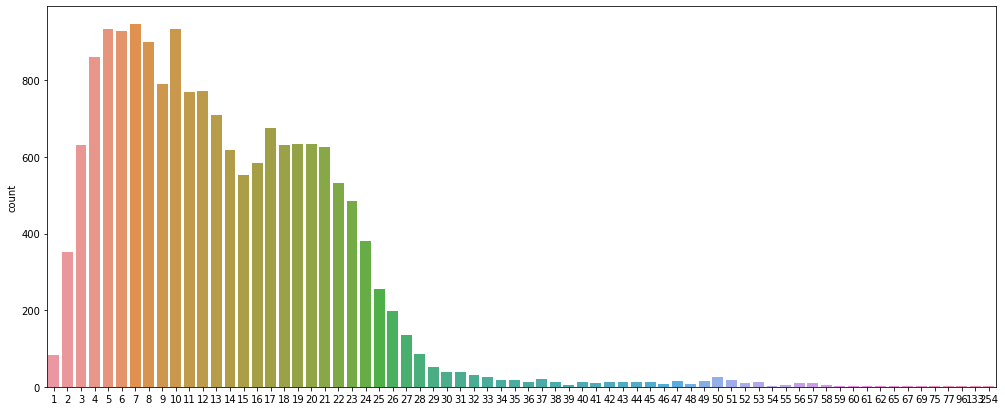

In [7]:
samples_length = []
for sample in text:
    sample_length = len(sample.split())
    samples_length.append(sample_length)

plt.figure(figsize=(17,7))
sns.countplot(samples_length)

We can see that the vast majority of the samples have 32 words or less, by setting max_length to 32, sentences that have more than 32 tokens will be truncated, and sentences that have less than 32 tokens will be padded with padding token

In [30]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    
    return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Check the first tokenized sample

In [31]:
token_id[0]

tensor([    2,  5796,  2247,  3582,  1010,   414,  3128,  2563,  1955, 16182,
         6398,   415,  1973,  2247, 13888, 13427, 11570,  2559,  1961,  8320,
         5796,  1973, 10431,  1973,  3379,  2494,  4131,     3,     0,     0,
            0,     0])

In [32]:
attention_masks[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0])

Now that we have our dataset cleaned, preprocessed, and tokenized, let's start training

## Training

In [33]:
# Load the pretrained model from huggingface

model = BertForSequenceClassification.from_pretrained(
    'CAMeL-Lab/bert-base-arabic-camelbert-da',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

In [34]:
val_ratio = 0.1
batch_size = 16

# Split dataset to train and validation
train_idx, val_idx = train_test_split(np.arange(len(labels)),
                                        test_size = val_ratio,
                                        shuffle = True,
                                        stratify = labels)

train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])


# Prepare DataLoaders
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size)

We need need to create functions for our validation metrics which are :
- Accuary
- precision
- Recall
- specificity

In [35]:
def b_tp(preds, labels):
    '''Returns True Positives (TP): count of correct predictions of actual class 1'''
    return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
    '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
    return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
    '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
    return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
    '''
    Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
    '''
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    tp = b_tp(preds, labels)
    tn = b_tn(preds, labels)
    fp = b_fp(preds, labels)
    fn = b_fn(preds, labels)
    b_accuracy = (tp + tn) / len(labels)
    b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
    b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
    b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
    return b_accuracy, b_precision, b_recall, b_specificity

In [36]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Use GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 4

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  25%|██▌       | 1/4 [01:37<04:53, 97.86s/it]


	 - Train loss: 0.3760
	 - Validation Accuracy: 0.8918
	 - Validation Precision: 0.8518
	 - Validation Recall: 0.9262
	 - Validation Specificity: 0.8635



Epoch:  50%|█████     | 2/4 [03:15<03:15, 97.57s/it]


	 - Train loss: 0.1911
	 - Validation Accuracy: 0.8999
	 - Validation Precision: 0.9201
	 - Validation Recall: 0.8720
	 - Validation Specificity: 0.9271



Epoch:  75%|███████▌  | 3/4 [04:52<01:37, 97.54s/it]


	 - Train loss: 0.1075
	 - Validation Accuracy: 0.9126
	 - Validation Precision: 0.8714
	 - Validation Recall: 0.9540
	 - Validation Specificity: 0.8722



Epoch: 100%|██████████| 4/4 [06:30<00:00, 97.57s/it]


	 - Train loss: 0.0754
	 - Validation Accuracy: 0.9132
	 - Validation Precision: 0.9014
	 - Validation Recall: 0.9192
	 - Validation Specificity: 0.9084



In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 4

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  25%|██▌       | 1/4 [01:37<04:53, 97.79s/it]


	 - Train loss: 0.3702
	 - Validation Accuracy: 0.8846
	 - Validation Precision: 0.9135
	 - Validation Recall: 0.8413
	 - Validation Specificity: 0.9248



Epoch:  50%|█████     | 2/4 [03:15<03:15, 97.51s/it]


	 - Train loss: 0.2073
	 - Validation Accuracy: 0.9091
	 - Validation Precision: 0.9067
	 - Validation Recall: 0.9024
	 - Validation Specificity: 0.9135



Epoch:  75%|███████▌  | 3/4 [04:52<01:37, 97.47s/it]


	 - Train loss: 0.1374
	 - Validation Accuracy: 0.9178
	 - Validation Precision: 0.9286
	 - Validation Recall: 0.9004
	 - Validation Specificity: 0.9306



Epoch: 100%|██████████| 4/4 [06:30<00:00, 97.54s/it]


	 - Train loss: 0.0814
	 - Validation Accuracy: 0.9230
	 - Validation Precision: 0.9336
	 - Validation Recall: 0.9005
	 - Validation Specificity: 0.9403



## Inference

In [46]:
sentence = 'ضع الجملة المراد تصنيفها هنا'

# Preprocess the setnence
new_sentence = preprocess_text(sentence)
new_sentence = plus_to_space(new_sentence)

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Toxic' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not Toxic'

print('Input Sentence: ', sentence)
print('Predicted Class: ', prediction)

Input Sentence:  ضع الجملة المراد تصنيفها هنا
Predicted Class:  Not Toxic


### Save the trained model and the tokenizer

In [47]:
model.save_pretrained('./model')

In [48]:
tokenizer.save_pretrained("./tokenizer")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json')